Import usefull libreries

In [19]:
from igraph import *
import numpy as np
from math import floor
from random import randint
from operator import itemgetter, attrgetter
from datetime import date
from time import localtime, strftime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Define the functions to perform the attacks:

In [20]:
# a function to generate the "robust version" of a given graph g
# according to the Barabasi algorithm
# see http://barabasi.com/networksciencebook/chapter/8#buildin-robustness
#     http://barabasi.com/networksciencebook/chapter/8#advanced-8g
def robust_graph(g):
    # compute coefficient A
    g_avg_d = mean(g.degree())
    A = ((2 * g_avg_d ** 2 * (g_avg_d-1)**2) / (2*g_avg_d-1)) ** (float(1)/3)
    g_N = g.vcount()
    
    # compute kmax and kmin according to A
    kmax = int(round(A * (g_N ** (float(2)/3))))
    kmin_low = int(floor((g_N * g_avg_d - kmax) / (g_N - 1)))
    
    # as kmin will be rounded, balance nodes with kmin_low and kmin_low+1 to keep
    # the total number of links and avg degree of the original graph
    rem = ((g_N * g_avg_d - kmax) / (g_N - 1)) - kmin_low
    # 1-rem% of nodes must have degree kmin_low, the rest kmin_low+1
    
    # create the degree sequence to generate the graph
    n_low = int(round((g_N-1) * (1-rem)))
    n_high = (g_N-1) - n_low
    seq_deg_low = [kmin_low for i in range(0,n_low)]
    seq_deg_high = [kmin_low+1 for i in range(0,n_high)]
    seq_deg = seq_deg_high + seq_deg_low
    seq_deg.insert(0,kmax)
    
    # create the "robust" graph
    try:
        g_rob = Graph.Degree_Sequence(seq_deg, method="vl")
        print ("Robust graph generated with method \"vl\"")
    except:
        try:
            g_rob = Graph.Degree_Sequence(seq_deg, method="no_multiple")
            print ("Robust graph generated with method \"no_multiple\"")
        except:
            g_rob = Graph.Degree_Sequence(seq_deg, method="simple")
            print ("Robust graph generated with method \"simple\"")

    return g_rob

In [21]:
DEBUG = True
GRANUL = 1000

sim_attacks = ["targ_deg_sim"]
seq_attacks = ["random", "targ_deg_seq"]
supported_attacks = sim_attacks + seq_attacks

# the list of nodes to attack in case of simultaneous attacks of type att_type
# assumes that vertices have a name, and returs the list of vertices to be attacked, by name
def attack_list(g, att_type):
    vert_cent = []
    if att_type == "targ_deg_sim":    
        # tuples with names and degrees
        vert_cent = [(v["name"], v.degree()) for idx, v in enumerate(g.vs())]

    # sort by the centrality metric in decreasing order
    vert_cent.sort(key=itemgetter(1), reverse=True)
    # no need to kill the last node
    del vert_cent[-1]
    # the IDs of the vertices to be killed, in order of killing
    kill_names = [elem[0] for elem in vert_cent]
    
    return kill_names


# executes a random attack pattern until no node is left, and returns the list of GC proportions
# with respect to the original graph
def attack(g_orig, att_type):
    
    # check that the attack can be done
    if att_type not in supported_attacks:
        print("Attack " + str(att_type) + " is not supported")
        return None

    # deepcopy to avoid modifications to the original graph
    g = deepcopy(g_orig)
    
    # prepare for the output list
    # each element is a tuple in the following form
    # (fraction of removed vertices, fraction of vertices still in the GC)
    initial_size = g.vcount()
    GC_frac = [(0,1)]
    
    # count the # of killed vertices
    killed = 0
    
    # simultaneous attacks
    if att_type in sim_attacks:
        # must refer to vertices by name, as indexes are recomputed after each deletion
        for idx in range(0,g.vcount()):
            g.vs[idx]["name"] = str(idx)
            
        # get the ordered list of vertices to kill (as a list of vertex names)
        kill_list = attack_list(g, att_type)
    
        for kill_name in kill_list:
            # find the id of the vertex to kill, and kill it
            kill_id = g.vs.find(kill_name).index
            g.delete_vertices(kill_id)
            killed += 1
            # compute the new GC size relative to the original one
            new_GC_size = max(g.clusters().sizes())
            new_point = (float(killed)/initial_size, float(new_GC_size)/initial_size)
            GC_frac.append(new_point)
            if DEBUG and (killed % GRANUL == 0):
                print ("initial_size - killed", new_point)
                if killed % (10*GRANUL) == 0:
                    print ('\n')
    
    # sequential attacks
    else:
        to_be_killed = g.vcount()
        while to_be_killed > 1:
            # pick the id of the node to attack
            if att_type == "random":
                kill_id = randint(0,to_be_killed-1)
            elif att_type == "targ_deg_seq":
                kill_id = np.argmax(g.degree())

            # kill the vertex
            g.delete_vertices(kill_id)
            killed += 1
            to_be_killed -= 1
            # compute the new GC size relative to the original one
            new_GC_size = max(g.clusters().sizes())
            # the new point in the series (fraction of killed nodes, fraction of nodes in the GC)
            new_point = (float(killed)/initial_size, float(new_GC_size)/initial_size)
            GC_frac.append(new_point)
            
            if DEBUG and (killed % GRANUL == 0):
                print ("to_be_killed", new_point)
                if killed % (10*GRANUL) == 0:
                    print ('\n')

    return GC_frac

# print the resulting robustness data in an ncol format
# <fraction of removed vertices> <fraction of vertices remaining in the GC>
def print_out(lst, file_name):
    try:
        out_file = open(file_name, "w")
        for elem in lst:
            print (elem[0], elem[1], sep = " ", file=out_file)
        out_file.close()
    except:
        print ("Cannot open file for writing output")

In [22]:
# main interface: perform_attacks() is what one should call to attack a graph.
#
# parameters
# - infile is the name of the file with the graph in ncol format
# - directed is whether the graph is directed or not
# - prefix is the subdir+prefix related to the dataset for the name of the outfile, e.g., brightkite/bkite
#   specifically,
#   - the subdir (brightkite in the example) is the folder where the dataset of the graph is available
#   - prefix (bkite in the example) is a prefix string that will be used
#     as the initial part of the name of the output files
#
# The function performs complete attacks of the following kinds
# 1. random
# 2. targeted to the degree, simultaneous
# 3. targeted to the degree, sequential
#
# The three attacks are replicated for the original and the robust version of the graph
#
# For each attack, a txt file is generated using the prefix parameter, with the points of the robustness curve
# Specifically, the output files
# - must be text files
# - in each line they must contain a point of the robustness curve for that particular attack
#   in the following format <fraction of removed vertices> <fraction of vertices remaining in the GC>
# - they will be created in the folder corresponding to the first part of the prefix (until the / character)

def perform_attacks(infile, directed, prefix):
    # load the graph and create its robust version
    g = read(infile, format="ncol", directed=directed)
    g_rob = robust_graph(g)

    # debug print, just to check how long the attacks take to complete
    print ("Random attack to the original graph")
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    # robustness of the original graph
    # performs the random attack on the graph
    g_orig_frac_random = attack(g, "random")
    # print the resulting robustness curve in one of the output files
    out_file = prefix + "_orig_frac_random.txt"
    print_out(g_orig_frac_random, out_file)

    
    # debug print, just to check how long the attacks take to complete
    print ("\n\nTargeted simultaneous attack to the original graph, using degree as centrality metric")
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    g_orig_frac_deg_sim = attack(g, "targ_deg_sim")
    out_file = prefix + "_orig_frac_deg_sim.txt"
    print_out(g_orig_frac_deg_sim, out_file)

    
    print ("\n\nTargeted sequential attack to the original graph, using degree as centrality metric")    
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    g_orig_frac_deg_seq = attack(g, "targ_deg_seq")
    out_file = prefix + "_orig_frac_deg_seq.txt"
    print_out(g_orig_frac_deg_seq, out_file)

    
    # robustness of the robust version of the graph
    print ("\n\nRandom attack to the robust graph")
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    g_rob_frac_random = attack(g_rob, "random")
    out_file = prefix + "_rob_frac_random.txt"
    print_out(g_rob_frac_random, out_file)


    print ("\n\nTargeted simultaneous attack to the robust graph, using degree as centrality metric")
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    g_rob_frac_deg_sim = attack(g_rob, "targ_deg_sim")
    out_file = prefix + "_rob_frac_deg_sim.txt"
    print_out(g_rob_frac_deg_sim, out_file)
    
    print ("\n\nTargeted sequential attack to the robust graph, using degree as centrality metric")
    print (strftime("Start time: %H:%M:%S", localtime()))
    print ("\nPoints in the robustness curve")
    g_rob_frac_deg_seq = attack(g_rob, "targ_deg_seq")
    out_file = prefix + "_rob_frac_deg_seq.txt"
    print_out(g_rob_frac_deg_seq, out_file)

    print (strftime("\n%H:%M:%S\n", localtime()))

In [23]:
# Function to read files with the reobustness points resulting from an attack
import re

# keeps a file name as input, which must be a set of lines with two numbers in each line, separated by white spaces
# returns a tuple composed by two lists
# - the first element is the list of x axes (the list of the numbers in the first position in each line)
# - the second element is the list of y axes (the list of the numbers in the second position in each line)
def read_xy(file):
    x = []
    y = []
    f = open(file, 'rU')
    for line in f:
        strings = re.findall(r'\d+\.?\d*e?[\+-]?\d?\d?', line)
        x.append(float(strings[0]))
        y.append(float(strings[1]))
    f.close()
    return (x,y)

The real work

In [ ]:
# Here is the code to start and execute the attacks on the graph - invoke perform_attacks() on the graph under analysis
# Example of attacks - the case of Brightkite

print ("Attacking Facebook\n\n")
perform_attacks("dataset/socfb-wosn-friends.cut.sb.10K.edges", directed=False, prefix="Facebook/fb")

Attacking Facebook


Robust graph generated with method "simple"
Random attack to the original graph
Start time: 21:23:43

Points in the robustness curve
to_be_killed (0.1, 0.8995)
to_be_killed (0.2, 0.7981)
to_be_killed (0.3, 0.6973)
to_be_killed (0.4, 0.5959)
to_be_killed (0.5, 0.4932)
to_be_killed (0.6, 0.3882)
to_be_killed (0.7, 0.2844)
to_be_killed (0.8, 0.1815)
to_be_killed (0.9, 0.0807)


Targeted simultaneous attack to the original graph, using degree as centrality metric
Start time: 21:26:07

Points in the robustness curve
initial_size - killed (0.1, 0.8888)


/home/osboxes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'U' mode is deprecated
  # This is added back by InteractiveShellApp.init_path()


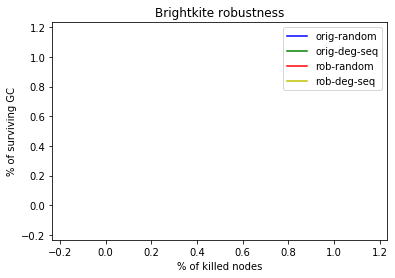

In [17]:
# read the files with the points of the robustness curves and plot the robustness curves

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages

# read the data from the respective files, putting everything into a dict
# each element in the dict stores the two vectors with the data for the corresponding curve
bk = {}
bk["or_rand"] = read_xy("Facebook/fb_orig_frac_random.txt")
bk["or_deg_seq"] = read_xy("Facebook/fb_orig_frac_deg_seq.txt")
bk["rob_rand"] = read_xy("Facebook/fb_rob_frac_random.txt")
bk["rob_deg_seq"] = read_xy("Facebook/fb_rob_frac_deg_seq.txt")

# plot the 4 curves in the same plot
_ = plt.plot(bk["or_rand"][0], bk["or_rand"][1], 'b-', label = "orig-random")
_ = plt.plot(bk["or_deg_seq"][0], bk["or_deg_seq"][1], 'g-', label = "orig-deg-seq")
_ = plt.plot(bk["rob_rand"][0], bk["rob_rand"][1], 'r-', label = "rob-random")
_ = plt.plot(bk["rob_deg_seq"][0], bk["rob_deg_seq"][1], 'y-', label = "rob-deg-seq")
_ = plt.xlabel("% of killed nodes")
_ = plt.ylabel("% of surviving GC")
_ = plt.title("Brightkite robustness")
_ = plt.legend()

# save the plot to a PDF file
pdf_file = PdfPages('fb_robustness.pdf')
plt.savefig(pdf_file, format="pdf")
pdf_file.close()

In [12]:
# read the files with the points of the robustness curves and plot the robustness curves

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages

# read the data from the respective files, putting everything into a dict
# each element in the dict stores the two vectors with the data for the corresponding curve
bk = {}
bk["or_deg_sim"] = read_xy("Facebook/fb_orig_frac_deg_sim.txt")
bk["or_module_based"] = read_xy("Facebook/fb_orig_frac_module_based.txt")
bk["rob_deg_sim"] = read_xy("Facebook/fb_rob_frac_deg_sim.txt")
bk["rob_module_based"] = read_xy("Facebook/fb_rob_frac_module_based.txt")

# plot the 4 curves in the same plot
_ = plt.plot(bk["or_deg_sim"][0], bk["or_deg_sim"][1], 'c-', label = "orig-deg-sim")
_ = plt.plot(bk["or_module_based"][0], bk["or_module_based"][1], 'm-', label = "orig-module_based")
_ = plt.plot(bk["rob_deg_sim"][0], bk["rob_deg_sim"][1], 'g-', label = "rob-deg-sim")
_ = plt.plot(bk["rob_module_based"][0], bk["rob_module_based"][1], 'y-', label = "rob-module_based")
_ = plt.xlabel("% of killed nodes")
_ = plt.ylabel("% of surviving GC")
_ = plt.title("youtube robustness - sim")
_ = plt.legend()

# save the plot to a PDF file
pdf_file = PdfPages('YT_robustness_sim.pdf')
plt.savefig(pdf_file, format="pdf")
pdf_file.close()

/home/osboxes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 'U' mode is deprecated
  # This is added back by InteractiveShellApp.init_path()


FileNotFoundError: [Errno 2] No such file or directory: 'Facebook/fb_orig_frac_module_based.txt'